# Forecast Average Session Duration for Top User

## Problem Statement
Select the top 1 user who has the highest number of sessions. Forecast the next 3 months of average session duration, starting from the last available record for that user.

In [1]:
import sys
sys.path.append('..')

from src.common.definition import (
    create_spark_session,
    load_track_data,
    add_sessions_id_columns,
)
from src.data_preparation import prepare_top_user_monthly_sessions_for_forecasting
from src.time_series_analysis import (
    check_stationarity,
    forecast_with_sarimax
)
from src.ml_models import (
    prepare_train_test_split,
    get_default_models_config,
    train_multiple_models,
    forecast_future_periods,
    create_forecast_dataframe
)
from src.visualization import (
    plot_forecast,
    plot_model_comparison
)
from sklearn.linear_model import Ridge
import numpy as np

# Configuration
DATA_PATH = "../userid-timestamp-artid-artname-traid-traname.tsv"
SESSION_GAP_SEC = 20 * 60  # 20 minutes
FORECAST_PERIODS = 3  # Next 3 months

In [2]:
spark = create_spark_session("exercise_2_forecasting")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/12/03 18:02:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
track_list = load_track_data(spark, DATA_PATH)
df_sessions = add_sessions_id_columns(track_list, SESSION_GAP_SEC)
df_pandas, top_user, n_sessions = prepare_top_user_monthly_sessions_for_forecasting(df_sessions)

print(f"Top User: {top_user}")
print(f"Number of Sessions: {n_sessions}")
df_pandas.tail(10)

25/12/03 18:03:08 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


25/12/03 18:03:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/03 18:03:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/03 18:03:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/03 18:03:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/03 18:03:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/12/03 18:03:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/03 18:03:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/03 18:03:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/12/03 18:03:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/03 18:03:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/03 18:03:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/12/03 18:03:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/03 18:03:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/03 18:03:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/12/03 18:03:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/03 18:03:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/03 18:03:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


25/12/03 18:03:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/03 18:03:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


25/12/03 18:03:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/03 18:03:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/03 18:03:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/03 18:03:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


25/12/03 18:03:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/03 18:03:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Top User: user_000833
Number of Sessions: 6897


,timestamp_month,count_months,avg_session_duration_sec
42,2008-08-01,42,3407.640625
43,2008-09-01,43,3607.699301
44,2008-10-01,44,3819.986900
45,2008-11-01,45,3199.653680
46,2008-12-01,46,2998.044053
47,2009-01-01,47,3155.716895
48,2009-02-01,48,2473.324873
49,2009-03-01,49,2280.703125
50,2009-04-01,50,2422.973856
51,2009-05-01,51,2527.093750


In [4]:
X_train, y_train, X_test, y_test = prepare_train_test_split(df_pandas)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 34
Test set size: 18


/opt/venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [5]:
models_config = get_default_models_config()
results_df = train_multiple_models(X_train, y_train, X_test, y_test, models_config)

print("\nModel Performance Comparison:")
display(results_df)

Training LinearRegression...


Training Ridge...


Training Lasso...
Training RandomForestRegressor...


Training GradientBoostingRegressor...


Training SVR...

Model Performance Comparison:


,model,best_params,rmse,r2
1,Ridge,{'alpha': 100.0},782.979375,0.037732
2,Lasso,{'alpha': 1.0},796.925653,0.003147
0,LinearRegression,"{'copy_X': True, 'fit_intercept': True}",797.049923,0.002836
5,SVR,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",903.887682,-0.282403
4,GradientBoostingRegressor,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",928.227514,-0.352397
3,RandomForestRegressor,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",982.673103,-0.515701


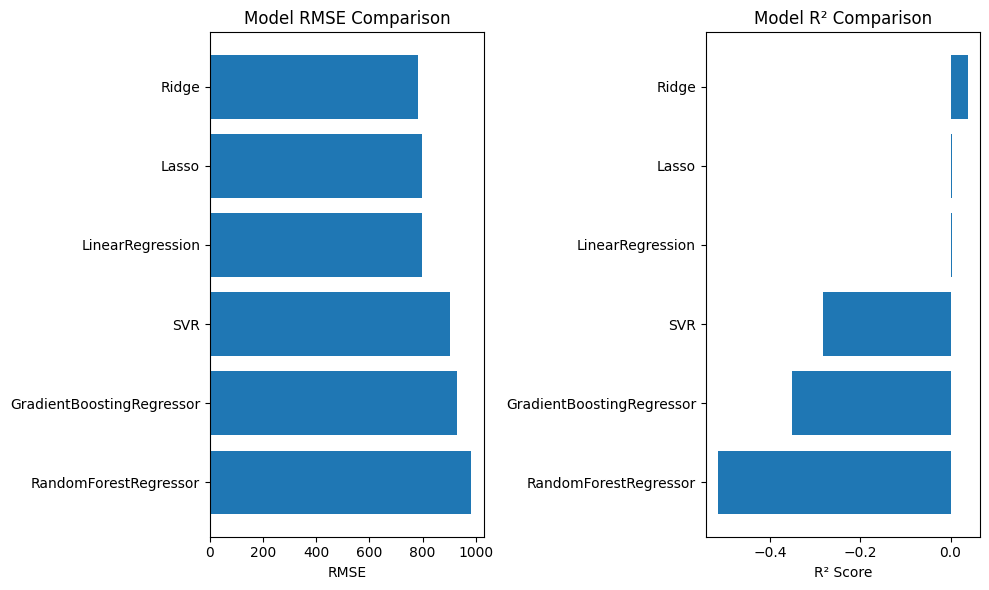

In [6]:
# Visualize model comparison
plot_model_comparison(results_df)

In [7]:
best_model_name = results_df.iloc[0]["model"]
best_params = results_df.iloc[0]["best_params"]

print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {best_params}")
print(f"RMSE: {results_df.iloc[0]['rmse']:.2f}")
print(f"R²: {results_df.iloc[0]['r2']:.4f}")

Best Model: Ridge
Best Parameters: {'alpha': 100.0}
RMSE: 782.98
R²: 0.0377


In [8]:
best_model = Ridge(random_state=42, **best_params)
last_month = df_pandas["count_months"].max()
future_t, predictions = forecast_future_periods(best_model, X_train, y_train, last_month, FORECAST_PERIODS)

print("\nBest ML Model - Future Predictions:")
for i, pred in enumerate(predictions, 1):
    print(f"Month +{i}: {pred:.2f} seconds ({pred/60:.2f} minutes)")


Best ML Model - Future Predictions:
Month +1: 2683.87 seconds (44.73 minutes)
Month +2: 2643.93 seconds (44.07 minutes)
Month +3: 2603.99 seconds (43.40 minutes)


/opt/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [9]:
last_date = df_pandas["timestamp_month"].max()
forecast_df_ml = create_forecast_dataframe(last_date, future_t, predictions)

print("\nML Model Forecast Summary:")
display(forecast_df_ml)


ML Model Forecast Summary:


,month,t,forecast_avg_session_duration_sec
0,2009-06-01,52,2683.873746
1,2009-07-01,53,2643.931989
2,2009-08-01,54,2603.990232


In [10]:
df_ts = df_pandas[["timestamp_month", "avg_session_duration_sec"]].set_index("timestamp_month")

stationarity = check_stationarity(df_ts["avg_session_duration_sec"])
print(f"ADF Statistic: {stationarity['adf_statistic']:.4f}")
print(f"p-value: {stationarity['p_value']:.4f}")
print(f"Stationary: {'Yes' if stationarity['is_stationary'] else 'No'}")

ADF Statistic: -3.8219
p-value: 0.0027
Stationary: Yes


In [11]:
results_sarimax, forecast_sarimax, metrics_sarimax = forecast_with_sarimax(
    df_ts,
    forecast_periods=FORECAST_PERIODS,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
)

print("\nSARIMAX Model Performance:")
print(f"MAE: {metrics_sarimax['mae']:.2f}")
print(f"MSE: {metrics_sarimax['mse']:.2f}")
print(f"RMSE: {np.sqrt(metrics_sarimax['mse']):.2f}")

print("\nSARIMAX - Future Predictions:")
for i, (date, pred) in enumerate(forecast_sarimax.items(), 1):
    print(f"Month +{i} ({date.strftime('%Y-%m')}): {pred:.2f} seconds ({pred/60:.2f} minutes)")

/opt/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



SARIMAX Model Performance:
MAE: 309.49
MSE: 243302.37
RMSE: 493.26

SARIMAX - Future Predictions:
Month +1 (2009-06): 3131.70 seconds (52.19 minutes)
Month +2 (2009-07): 2424.86 seconds (40.41 minutes)
Month +3 (2009-08): 2451.50 seconds (40.86 minutes)


/opt/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


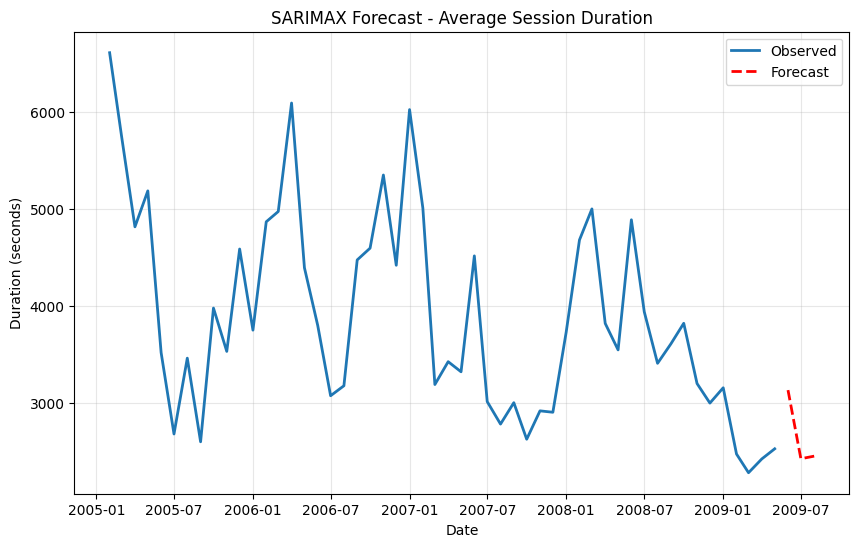

In [12]:
plot_forecast(
    df_ts,
    forecast_sarimax,
    title="SARIMAX Forecast - Average Session Duration",
    ylabel="Duration (seconds)"
)

In [13]:

print(f"\nTop User: {top_user} (with {n_sessions} sessions)")
print(f"\nModel Performance Comparison:")
print(f"  Best ML Model ({best_model_name}):")
print(f"    RMSE: {results_df.iloc[0]['rmse']:.2f} seconds")
print(f"    R²: {results_df.iloc[0]['r2']:.4f}")
print(f"\n  SARIMAX (Time Series Baseline):")
print(f"    RMSE: {np.sqrt(metrics_sarimax['mse']):.2f} seconds")
print(f"    MAE: {metrics_sarimax['mae']:.2f} seconds")

print(f"FORECAST FOR NEXT {FORECAST_PERIODS} MONTHS")
print(f"\nUsing Best Model: {best_model_name}")
print(f"\nPredicted Average Session Duration:")
for i, (date, pred) in enumerate(zip(forecast_df_ml['month'], forecast_df_ml['forecast_avg_session_duration_sec']), 1):
    print(f"  Month +{i} ({date.strftime('%Y-%m')}): {pred:.2f} seconds ({pred/60:.2f} minutes)")



Top User: user_000833 (with 6897 sessions)

Model Performance Comparison:
  Best ML Model (Ridge):
    RMSE: 782.98 seconds
    R²: 0.0377

  SARIMAX (Time Series Baseline):
    RMSE: 493.26 seconds
    MAE: 309.49 seconds
FORECAST FOR NEXT 3 MONTHS

Using Best Model: Ridge

Predicted Average Session Duration:
  Month +1 (2009-06): 2683.87 seconds (44.73 minutes)
  Month +2 (2009-07): 2643.93 seconds (44.07 minutes)
  Month +3 (2009-08): 2603.99 seconds (43.40 minutes)


## Cleanup

In [14]:
spark.stop()